In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
rules = pd.read_csv("test-recommend-output-wocDepSeq-all.csv")
to_lib2max_freq = {to_lib: max(row["ruleFreqSameCommit"]) for to_lib, row in rules.groupby(by="toGroupArtifact")}
rules["ruleFreqToLibSameCommit"] = rules["ruleFreqSameCommit"] / rules["toGroupArtifact"].apply(lambda x: to_lib2max_freq[x])
rules["confTeyton"] = np.minimum(rules["ruleFreqSameCommit"], rules["ruleFreqToLibSameCommit"]).fillna(0)
to_lib2max_freq = {to_lib: max(row["ruleFreq"]) for to_lib, row in rules.groupby(by="toGroupArtifact")}
rules["ruleFreqToLib"] = rules["ruleFreq"] / rules["toGroupArtifact"].apply(lambda x: to_lib2max_freq[x])

ground_truth = pd.read_csv("possible-ground-truth-2014.csv")
confirmed_rule_set = set(zip(
    ground_truth[ground_truth["dataConfirmed"]]["fromGroupArtifact"], 
    ground_truth[ground_truth["dataConfirmed"]]["toGroupArtifact"]
))
possible_rule_set = set(zip(
    ground_truth[ground_truth["inDepSeq"] > 0]["fromGroupArtifact"], 
    ground_truth[ground_truth["inDepSeq"] > 0]["toGroupArtifact"]
))
rules["isPossible"] = [x in possible_rule_set for x in zip(rules["fromGroupArtifact"], rules["toGroupArtifact"])]
rules["isConfirmed"] = [x in confirmed_rule_set for x in zip(rules["fromGroupArtifact"], rules["toGroupArtifact"])]
rules["popularityRegularization"] = rules["ruleFreq"] * rules["concurrenceAdjustment"] ** 0.25
rules["confidence"] = (rules["ruleFreq"] * (rules["concurrenceAdjustment"] ** 0.25)
                           * rules["apiSupport"].apply(lambda x: max(0.1, x)) ** 0.5
                           * rules["positionSupport"] ** 2)
possible_rules = rules[rules["isPossible"]]
confirmed_rules = rules[rules["isConfirmed"]]
other_rules = rules[~rules["isConfirmed"] & ~rules["isPossible"]]
print("# rules = {}, # confirmed = {}, # possible = {}, # other = {}".format(
    len(rules), len(confirmed_rules), len(possible_rules), len(other_rules)))

# rules = 475022, # confirmed = 289, # possible = 1288, # other = 473734


In [3]:
rules

,fromGroupArtifact,toGroupArtifact,isCorrect,confidence,ruleCountSameCommit,ruleCount,ruleFreqSameCommit,ruleFreq,concurrence,concurrenceAdjustment,positionSupport,commitDistance,apiSupport,ruleFreqToLibSameCommit,confTeyton,isPossible,isConfirmed,popularityRegularization
0,antlr:antlr,io.micrometer:micrometer-core,False,2.089978e-01,0,21,0.000000,0.750000,24,0.875000,0.954529,0.243386,0.0,0.000000,0.000000,False,False,0.725376
1,antlr:antlr,com.google.protobuf:protobuf-gradle-plugin,False,1.163592e-01,0,19,0.000000,0.678571,22,0.863636,0.750000,0.039357,0.0,NaN,0.000000,False,False,0.654151
2,antlr:antlr,org.eclipse.jetty:jetty-server,False,1.309990e-01,1,24,0.035714,0.857143,49,0.489796,0.760073,0.176797,0.0,0.071429,0.035714,False,False,0.717062
3,antlr:antlr,org.eclipse.jetty:jetty-webapp,False,7.045112e-02,1,22,0.035714,0.785714,51,0.431373,0.591500,0.115274,0.0,0.083333,0.035714,False,False,0.636763
4,antlr:antlr,org.antlr:antlr-complete,False,3.549162e-02,4,4,0.142857,0.142857,4,1.000000,0.886364,1.000000,0.0,1.000000,0.142857,False,False,0.142857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475017,xstream:xstream,tomcat:jasper-compiler,False,1.044369e-06,0,1,0.000000,0.016393,10,0.100000,0.018927,0.000567,0.0,0.000000,0.000000,False,False,0.009219
475018,xstream:xstream,tomcat:jasper-compiler-jdt,False,9.814703e-07,0,1,0.000000,0.016393,10,0.100000,0.018349,0.000567,0.0,0.000000,0.000000,False,False,0.009219
475019,xstream:xstream,jetty:org.mortbay.jetty,False,9.695738e-07,0,1,0.000000,0.016393,10,0.100000,0.018237,0.000567,0.0,0.000000,0.000000,False,False,0.009219
475020,xstream:xstream,tomcat:jasper-runtime,False,9.578923e-07,0,1,0.000000,0.016393,10,0.100000,0.018127,0.000567,0.0,0.000000,0.000000,False,False,0.009219


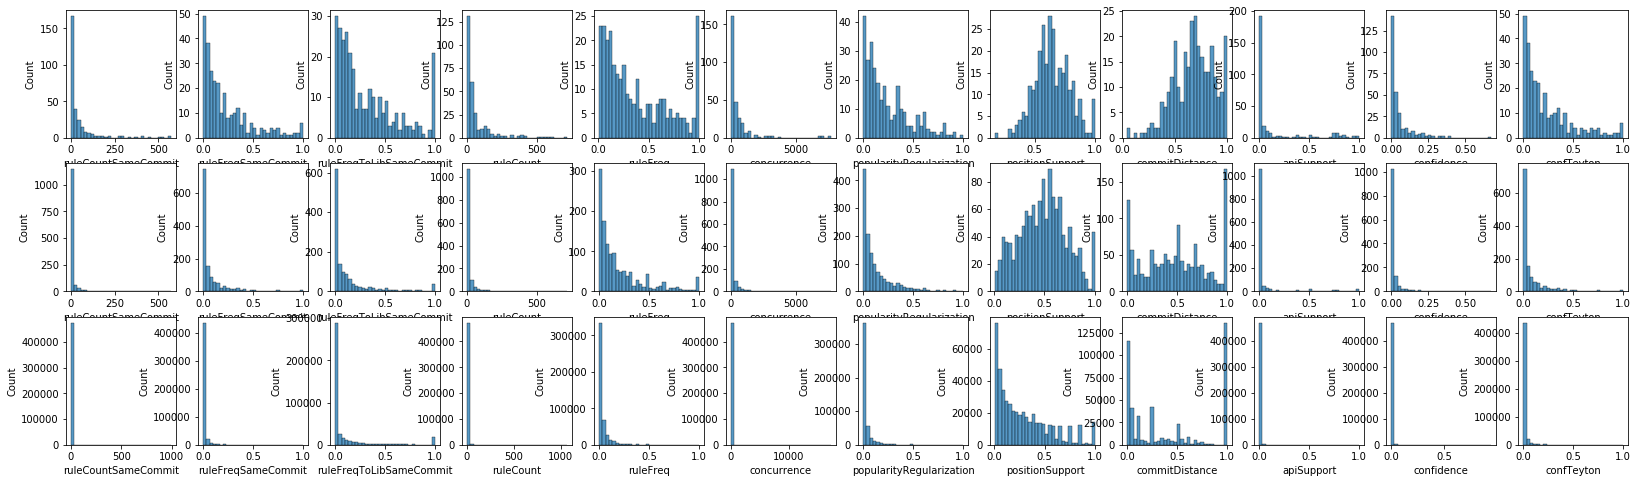

In [4]:
data = [rules[rules["isConfirmed"]], rules[rules["isPossible"]], rules[(~rules["isPossible"]) & (~rules["isConfirmed"])]]
axis = [
    "ruleCountSameCommit", "ruleFreqSameCommit", "ruleFreqToLibSameCommit",
    "ruleCount", "ruleFreq", "concurrence", "popularityRegularization", 
    "positionSupport", "commitDistance", "apiSupport", "confidence", "confTeyton"
]
fig, axes = plt.subplots(3, len(axis), figsize=(28, 8))
for i in range(0, 3):
    for j in range(0, len(axis)):
        sns.histplot(data=data[i], x=axis[j], ax=axes[i][j], bins=30)
fig.show()

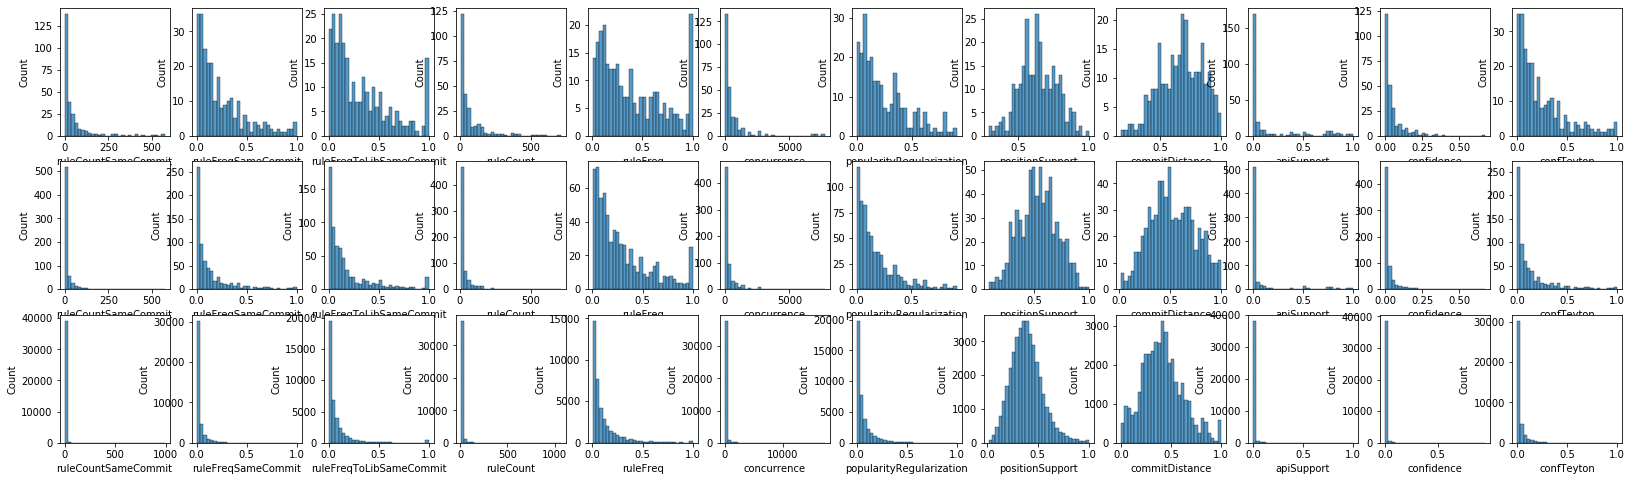

In [5]:
filtered_rules = rules[(rules["ruleCount"] >= 5) & (rules["concurrence"] >= 10)]
filtered_possible_rules = filtered_rules[filtered_rules["isPossible"]]
filtered_confirmed_rules = filtered_rules[filtered_rules["isConfirmed"]]
data = [
    filtered_rules[filtered_rules["isConfirmed"]], 
    filtered_rules[filtered_rules["isPossible"]], 
    filtered_rules[(~filtered_rules["isPossible"]) & (~filtered_rules["isConfirmed"])]
]
fig, axes = plt.subplots(3, len(axis), figsize=(28, 8))
for i in range(0, 3):
    for j in range(0, len(axis)):
        sns.histplot(data=data[i], x=axis[j], ax=axes[i][j], bins=30)
fig.show()

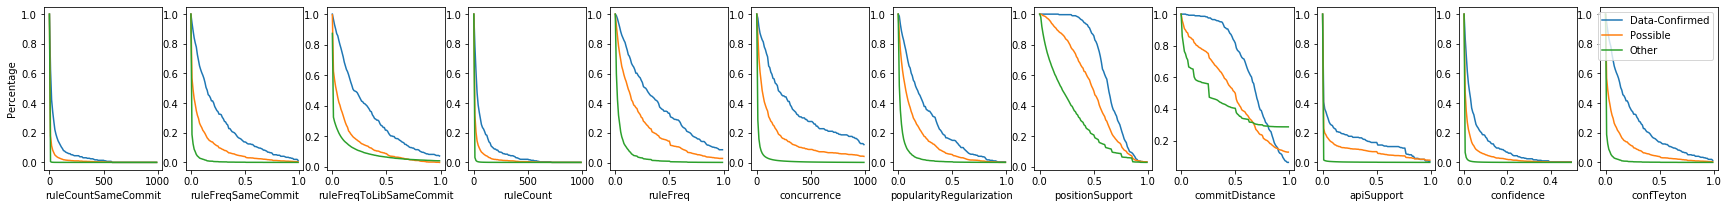

In [6]:
def get_dist(rules, possible_rules, confirmed_rules, metric, min_val, max_val, interval):
    possible_vals = []
    confirmed_vals = []
    other_vals = []
    for i in np.arange(min_val, max_val, interval):
        possible_vals.append(len(possible_rules[possible_rules[metric] >= i]) / len(possible_rules))
        confirmed_vals.append(len(confirmed_rules[confirmed_rules[metric] >= i]) / len(confirmed_rules))
        other_vals.append(len(other_rules[other_rules[metric] >= i]) / len(other_rules))
    return possible_vals, confirmed_vals, other_vals
params = [
    ("ruleCountSameCommit", 0, 1000, 10),
    ("ruleFreqSameCommit", 0, 1, 0.01),
    ("ruleFreqToLibSameCommit", 0, 1, 0.01),
    ("ruleCount", 0, 1000, 10), 
    ("ruleFreq", 0, 1, 0.01), 
    ("concurrence", 0, 1000, 10), 
    ("popularityRegularization", 0, 1, 0.01),
    ("positionSupport", 0, 1, 0.01), 
    ("commitDistance", 0, 1, 0.01), 
    ("apiSupport", 0, 1, 0.01),
    ("confidence", 0, 0.5, 0.005),
    ("confTeyton", 0, 1, 0.01)
]
fig, axes = plt.subplots(1, len(params), figsize=(30, 3))
for i, param in enumerate(params):
    possible, confirmed, other = get_dist(rules, possible_rules, confirmed_rules, *param)
    x = list(np.arange(param[1], param[2], param[3]))
    axes[i].plot(x, confirmed, label="Data-Confirmed")
    axes[i].plot(x, possible, label="Possible")
    axes[i].plot(x, other, label="Other")
    axes[i].set_xlabel(param[0])
    if i == 0:
        axes[i].set_ylabel("Percentage")
    if i == len(params) - 1:
        axes[i].legend()
fig.show()

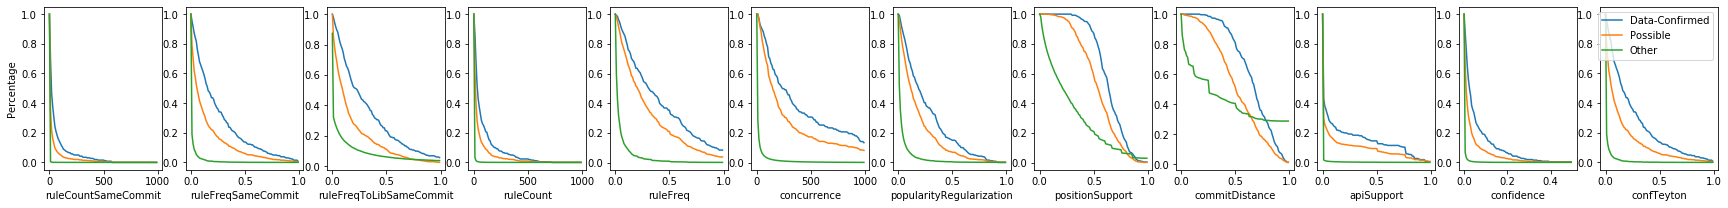

In [7]:
fig, axes = plt.subplots(1, len(params), figsize=(30, 3))
for i, param in enumerate(params):
    possible, confirmed, other = get_dist(filtered_rules, filtered_possible_rules, filtered_confirmed_rules, *param)
    x = list(np.arange(param[1], param[2], param[3]))
    axes[i].plot(x, confirmed, label="Data-Confirmed")
    axes[i].plot(x, possible, label="Possible")
    axes[i].plot(x, other, label="Other")
    axes[i].set_xlabel(param[0])
    if i == 0:
        axes[i].set_ylabel("Percentage")
    if i == len(params) - 1:
        axes[i].legend()
fig.show()

In [8]:
def show_dist2(filter_func):
    print("# possible = {}({:.2%}), # confirmed = {}({:.2%}), # other = {}({:.2%})".format(
            len(filter_func(possible_rules)),
            len(filter_func(possible_rules)) / len(possible_rules),
            len(filter_func(confirmed_rules)),
            len(filter_func(confirmed_rules)) / len(confirmed_rules),
            len(filter_func(other_rules)),
            len(filter_func(other_rules)) / len(other_rules),
    ))
show_dist2(lambda rules: rules[(rules["ruleCount"] >= 5) & (rules["concurrence"] >= 10)])
show_dist2(lambda rules: rules[(rules["ruleCount"] >= 2) & (rules["concurrence"] >= 15) & (rules["positionSupport"] >= 0.4)])

# possible = 659(51.16%), # confirmed = 261(90.31%), # other = 39381(8.31%)
# possible = 641(49.77%), # confirmed = 259(89.62%), # other = 30619(6.46%)


In [9]:
def show_dist(metric, min_val, max_val, interval):
    possible_rules = rules[rules["isPossible"]]
    confirmed_rules = rules[rules["isConfirmed"]]
    other_rules = rules[~rules["isConfirmed"] & ~rules["isPossible"]]
    print("Distribution of {}:".format(metric))
    for i in np.arange(min_val, max_val, interval):
        print("{} >= {:.2f}: # possible = {}({:.2%}), # confirmed = {}({:.2%}), # other = {}({:.2%})".format(
            metric, i,
            len(possible_rules[possible_rules[metric] >= i]),
            len(possible_rules[possible_rules[metric] >= i]) / len(possible_rules),
            len(confirmed_rules[confirmed_rules[metric] >= i]),
            len(confirmed_rules[confirmed_rules[metric] >= i]) / len(confirmed_rules),
            len(other_rules[other_rules[metric] >= i]),
            len(other_rules[other_rules[metric] >= i]) / len(other_rules),
        ))
    print("")
params = [
    ("ruleCountSameCommit", 0, 30, 1), 
    ("ruleFreqSameCommit", 0, 1, 0.02), 
    ("ruleCount", 0, 30, 1), 
    ("ruleFreq", 0, 1, 0.02), 
    ("concurrence", 0, 30, 1), 
    ("concurrenceAdjustment", 0, 1, 0.02),
    ("positionSupport", 0, 1, 0.02), 
    ("apiSupport", 0, 1, 0.02)
]
for param in params:
    show_dist(*param)

Distribution of ruleCountSameCommit:
ruleCountSameCommit >= 0.00: # possible = 1288(100.00%), # confirmed = 289(100.00%), # other = 473734(100.00%)
ruleCountSameCommit >= 1.00: # possible = 857(66.54%), # confirmed = 284(98.27%), # other = 162486(34.30%)
ruleCountSameCommit >= 2.00: # possible = 605(46.97%), # confirmed = 269(93.08%), # other = 42698(9.01%)
ruleCountSameCommit >= 3.00: # possible = 467(36.26%), # confirmed = 257(88.93%), # other = 19248(4.06%)
ruleCountSameCommit >= 4.00: # possible = 397(30.82%), # confirmed = 240(83.04%), # other = 11605(2.45%)
ruleCountSameCommit >= 5.00: # possible = 342(26.55%), # confirmed = 220(76.12%), # other = 7949(1.68%)
ruleCountSameCommit >= 6.00: # possible = 306(23.76%), # confirmed = 214(74.05%), # other = 5810(1.23%)
ruleCountSameCommit >= 7.00: # possible = 280(21.74%), # confirmed = 207(71.63%), # other = 4502(0.95%)
ruleCountSameCommit >= 8.00: # possible = 266(20.65%), # confirmed = 198(68.51%), # other = 3633(0.77%)
ruleCountSameC